In [1]:
# imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mne
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sns.set_theme(style="whitegrid")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


In [2]:
# Paths
preprocessed_path = "./../data/preprocessed/"
feature_extractor_weights_path = "./../validation module/feature_extractor_model/eeg_feature_extractor.pth"

In [3]:
# loading the data
def load_all_preprocessed_data(preprocessed_root="./../data/preprocessed/", num_classes=2):
    subject_folders = [d for d in os.listdir(preprocessed_root) if os.path.isdir(os.path.join(preprocessed_root, d))]
    all_data = []
    all_labels = []

    for subj in subject_folders:
        fif_path = os.path.join(preprocessed_root, subj, "preprocessed_epochs-epo.fif")
        if os.path.exists(fif_path):
            epochs = mne.read_epochs(fif_path, preload=True)
            data = epochs.get_data()
            events = epochs.events


            labels_int = events[:, 2]
            unique_codes = np.unique(labels_int)

            # If only one event code is found, randomly split epochs into two classes.
            if len(unique_codes) < 2:
                print(f"Subject {subj}: Only one event code found. Randomly splitting epochs into two classes.")
                n_epochs = data.shape[0]
                # Randomly shuffle indices and split into two halves.
                indices = np.arange(n_epochs)
                np.random.shuffle(indices)
                labels_int = np.zeros(n_epochs, dtype=int)
                split_idx = n_epochs // 2
                labels_int[indices[split_idx:]] = 1
            else:
                # If more than two codes, take only the first two
                if len(unique_codes) > 2:
                    unique_codes = unique_codes[:2]
                mapping = {unique_codes[0]: 0, unique_codes[1]: 1}
                labels_int = np.vectorize(lambda x: mapping.get(x, 0))(labels_int)

            # One-hot encode the labels
            labels_onehot = np.zeros((len(labels_int), num_classes))
            labels_onehot[np.arange(len(labels_int)), labels_int] = 1

            all_data.append(data)
            all_labels.append(labels_onehot)
        else:
            print(f"File {fif_path} not found. Skipping subject {subj}.")

    if len(all_data) == 0:
        raise RuntimeError("No preprocessed data found.")

    # Concatenate data across subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print("Loaded preprocessed EEG data shape:", all_data.shape)
    print("Loaded labels shape:", all_labels.shape)
    return all_data, all_labels

data, labels = load_all_preprocessed_data(preprocessed_path)
data = data.astype(np.float32)
labels = labels.astype(np.float32)

print("Data shape:", data.shape, "Labels shape:", labels.shape)

Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub42/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub11/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/validation module/../data/preprocessed/Sub29/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CT

In [4]:
# prepraring data loaders

X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# defining the model
class EEGFeatureExtractor(nn.Module):
    def __init__(self, n_channels=63, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = EEGFeatureExtractor().to(device)

In [6]:
# defining training criterion and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [7]:
# training loop

epochs = 50
best_val_acc = 0
patience = 10
patience_counter = 0

train_losses, val_losses, val_accs = [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch.argmax(dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch.argmax(dim=1))
            val_loss += loss.item()
            correct += (logits.argmax(dim=1) == y_batch.argmax(dim=1)).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = correct / len(val_dataset)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), feature_extractor_weights_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] | Train Loss: 0.6937 | Val Loss: 0.6942 | Val Acc: 0.4696
Epoch [2/50] | Train Loss: 0.6931 | Val Loss: 0.6948 | Val Acc: 0.4751
Epoch [3/50] | Train Loss: 0.6932 | Val Loss: 0.6955 | Val Acc: 0.4751
Epoch [4/50] | Train Loss: 0.6925 | Val Loss: 0.6951 | Val Acc: 0.4751
Epoch [5/50] | Train Loss: 0.6925 | Val Loss: 0.6955 | Val Acc: 0.4696
Epoch [6/50] | Train Loss: 0.6927 | Val Loss: 0.6971 | Val Acc: 0.4751
Epoch [7/50] | Train Loss: 0.6932 | Val Loss: 0.6955 | Val Acc: 0.4641
Epoch [8/50] | Train Loss: 0.6921 | Val Loss: 0.6940 | Val Acc: 0.4696
Epoch [9/50] | Train Loss: 0.6933 | Val Loss: 0.6936 | Val Acc: 0.5249
Epoch [10/50] | Train Loss: 0.6921 | Val Loss: 0.6956 | Val Acc: 0.4586
Epoch [11/50] | Train Loss: 0.6922 | Val Loss: 0.6970 | Val Acc: 0.4751
Epoch [12/50] | Train Loss: 0.6918 | Val Loss: 0.6968 | Val Acc: 0.4696
Epoch [13/50] | Train Loss: 0.6917 | Val Loss: 0.6956 | Val Acc: 0.4641
Epoch [14/50] | Train Loss: 0.6913 | Val Loss: 0.6964 | Val Acc: 0.4696
E

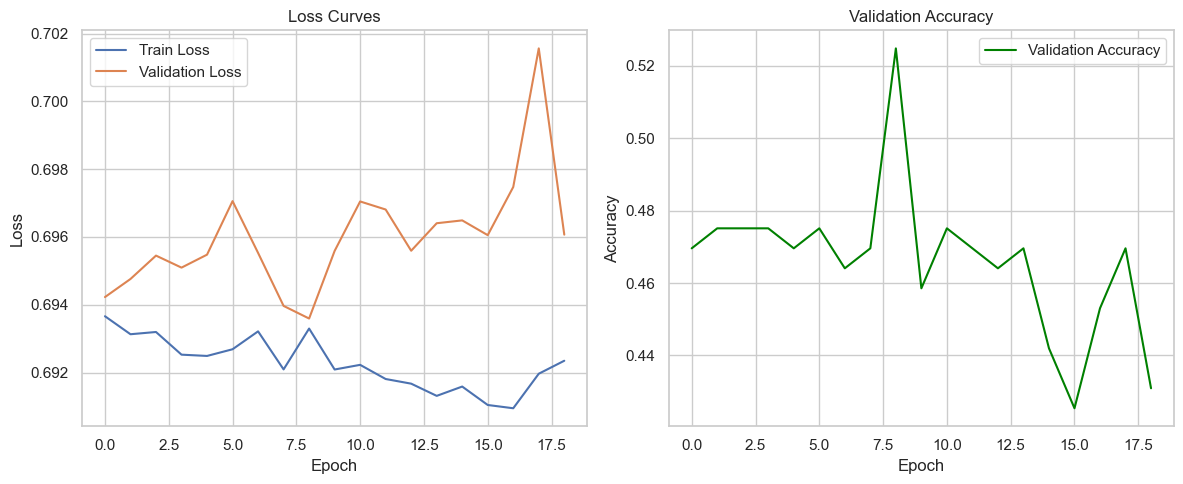

In [8]:
# Plot Training Results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [9]:
# best model loading
model.load_state_dict(torch.load(feature_extractor_weights_path))
model.eval()
print("Best EEG Feature Extractor loaded for use.")

Best EEG Feature Extractor loaded for use.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_11031/3820605267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(feature_extr